# Herdez Forecast Project

**Notebook created on:** 2024-09-30



In [1]:
# librerías necesarias
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

## Predicción de Venta_piezas

In [2]:
# dataset
df = pd.read_csv("..\\data\\dataset\\dataset.csv")
df.head()

,Anio,Semana,Sucursal,Cadena,Nivel Socioeconomico,Recurso,Venta_piezas,Venta_valor,Precio,Promocion,date,season,holiday,EventoEspecial_Venta_piezas,porcentaje_gasto_alimentos
0,2020,46,Norte 286,SA,D/E,68524 Alimentos,226.0,4428.999999,19.597345,0,2020-11-09,Otoño,0,0,47
1,2021,20,Norte 286,SA,D/E,68524 Alimentos,154.0,2754.809999,17.888377,1,2021-05-17,Primavera,1,0,47
2,2018,23,Norte 286,SA,D/E,68524 Alimentos,228.0,3176.590000,13.932412,1,2018-06-04,Primavera,0,0,47
3,2021,37,Norte 286,SA,D/E,68524 Alimentos,163.0,3112.000000,19.092025,0,2021-09-13,Verano,1,0,47
4,2020,10,Norte 286,SA,D/E,68524 Alimentos,212.0,3885.500000,18.327830,0,2020-03-02,Sin estacion,0,0,47


In [3]:
# Establecer 'date' como indice y ordenarlo
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df = df.sort_index()

In [4]:
# Definir la variable objetivo (Venta_piezas) y las variables exógenas
target = df["Venta_piezas"]
exog = df[["Promocion", "EventoEspecial_Venta_piezas"]]

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(target) * 0.8)
train_target, test_target = target[:train_size], target[train_size:]
train_exog, test_exog = exog[:train_size], exog[train_size:]

In [5]:
# Modelo SARIMAX con estacionalidad semanal de 52 semanas
model = SARIMAX(
    train_target, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)
)
results = model.fit()

c:\Users\DAVID\anaconda3\envs\test_arq_data\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\DAVID\anaconda3\envs\test_arq_data\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\DAVID\anaconda3\envs\test_arq_data\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\DAVID\anaconda3\envs\test_arq_data\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

In [6]:
# Forecast del conjunto de prueba
forecast_steps = len(test_target)
forecast = results.get_forecast(steps=forecast_steps, exog=test_exog)
forecast_df = forecast.summary_frame()

In [7]:
# Extraer los valores pronosticados (mean) y los intervalos de confianza (mean_ci_lower/upper)
forecast_values = forecast_df["mean"]
ci_lower = forecast_df["mean_ci_lower"]
ci_upper = forecast_df["mean_ci_upper"]

In [8]:
# Evaluar el pronóstico de Venta_piezas utilizando MAE, RMSE, y MAPE
mae_venta_piezas = mean_absolute_error(test_target, forecast_values)
rmse_venta_piezas = np.sqrt(mean_squared_error(test_target, forecast_values))
mape_venta_piezas = np.mean(np.abs((test_target - forecast_values) / test_target)) * 100

# Imprimir los resultados de evaluación de Venta_piezas
print(f"MAE para Venta_piezas: {mae_venta_piezas:.2f}")
print(f"RMSE para Venta_piezas: {rmse_venta_piezas:.2f}")
print(f"MAPE para Venta_piezas: {mape_venta_piezas:.2f}%")

MAE para Venta_piezas: 120.80
RMSE para Venta_piezas: 151.98
MAPE para Venta_piezas: 60.91%


## Prediccion de Precio para estimar Venta_valor

In [9]:
# Uso del mismo conjunto de prueba y entrenamiento para entrenar y evaluar el modelo de precio
X_train, X_test = train_exog, test_exog
y = df["Precio"]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Crear y ajustar el modelo de regresion lineal
price_model = LinearRegression()
price_model.fit(X_train, y_train)

# Hacer predicciones de Precio para el conjunto de prueba
predicted_prices = price_model.predict(X_test)

# Asegurarnos de que las predicciones de precio y las predicciones de piezas vendidas tengan el mismo numero de muestras
assert len(predicted_prices) == len(
    forecast_values
), "Número de predicciones de Precio y Venta_piezas no coinciden."


In [11]:
# Evaluar el modelo de Precio
mae_price = mean_absolute_error(y_test, predicted_prices)
rmse_price = np.sqrt(mean_squared_error(y_test, predicted_prices))

# Imprimir los resultados de evaluación de Precio
print(f"MAE para Precio: {mae_price:.2f}")
print(f"RMSE para Precio: {rmse_price:.2f}")

MAE para Precio: 2.28
RMSE para Precio: 2.70


Mean Absolute Error (MAE): 1.83:

Esto significa que, en promedio, la diferencia entre los precios reales y los predichos es de 1.83.
Un MAE relativamente bajo indica que el modelo tiene un buen desempeño en la predicción de los precios.

Root Mean Squared Error (RMSE): 2.38:

El RMSE penaliza los errores más grandes, y con un valor de 2.38, indica que el modelo comete un error promedio de 2.15 unidades en las predicciones.

In [12]:
# Estimar el valor de ventas multiplicando la predicción de Venta_piezas por la predicción de Precio
predicted_venta_valor = forecast_values * predicted_prices

# Evaluar el modelo de Venta_valor utilizando las ventas reales y los precios reales del conjunto de prueba
actual_venta_valor = test_target * y_test

# Asegurarnos de que las muestras coincidan
assert len(predicted_venta_valor) == len(
    actual_venta_valor
), "Número de muestras en actual_venta_valor y predicted_venta_valor no coinciden."

In [13]:
# Evaluar el modelo de Venta_valor utilizando las ventas reales y los precios reales del conjunto de prueba
mae_venta_valor = mean_absolute_error(actual_venta_valor, predicted_venta_valor)
rmse_venta_valor = np.sqrt(
    mean_squared_error(actual_venta_valor, predicted_venta_valor)
)
mape_venta_valor = (
    np.mean(np.abs((actual_venta_valor - predicted_venta_valor) / actual_venta_valor))
    * 100
)

# Imprimir los resultados de evaluación de Venta_valor
print(f"MAE para Venta_valor: {mae_venta_valor:.2f}")
print(f"RMSE para Venta_valor: {rmse_venta_valor:.2f}")
print(f"MAPE para Venta_valor: {mape_venta_valor:.2f}%")

MAE para Venta_valor: 1972.41
RMSE para Venta_valor: 2506.39
MAPE para Venta_valor: 52.54%


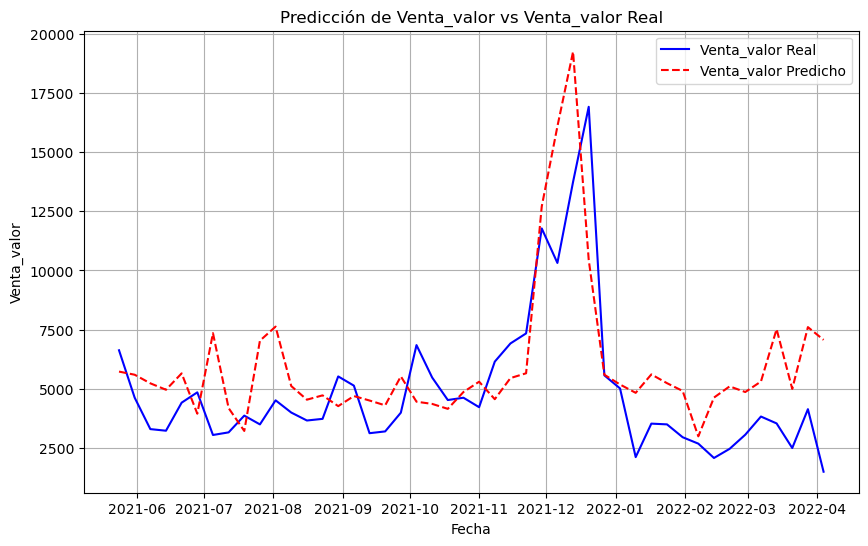

In [14]:
# Crear una figura y un conjunto de ejes
plt.figure(figsize=(10, 6))

# Graficar los valores reales de Venta_valor
plt.plot(
    df.index[train_size:], actual_venta_valor, label="Venta_valor Real", color="blue"
)

# Graficar los valores predichos de Venta_valor
plt.plot(
    df.index[train_size:],
    predicted_venta_valor,
    label="Venta_valor Predicho",
    color="red",
    linestyle="--",
)

# Añadir título y etiquetas
plt.title("Predicción de Venta_valor vs Venta_valor Real")
plt.xlabel("Fecha")
plt.ylabel("Venta_valor")

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

## Pronóstico a 52 semanas en el futuro

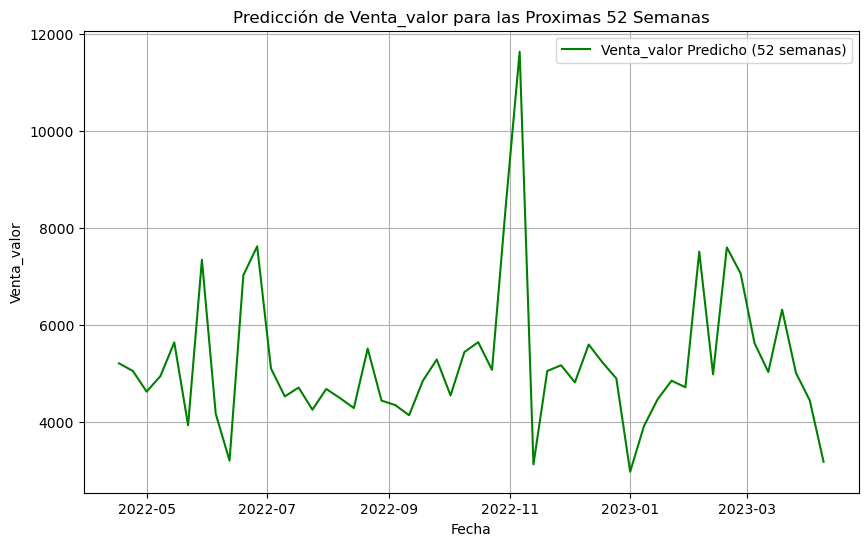

In [15]:
# Extender las variables exogenas para las próximas 52 semanas
# Las fechas futuras deben comenzar despues del ultimo indice en los datos historicos
last_date = df.index[-1]  ###### ultima fecha en los datos históricos


future_dates = pd.date_range(
    start=last_date + pd.Timedelta(weeks=1), periods=52, freq="W"
)

# Crear el DataFrame de variables exogenas futuras
future_exog = pd.DataFrame(
    {
        "Promocion": [0] * 52,
        "EventoEspecial_Venta_piezas": [0] * 52,
    },
    index=future_dates,
)

# Pronostico de Venta_piezas
future_forecast = results.get_forecast(steps=52, exog=future_exog)
future_forecast_df = future_forecast.summary_frame()

# Pronstico de Precio
future_predicted_prices = price_model.predict(future_exog)

# Estimar Venta_valor
future_venta_valor = future_forecast_df["mean"] * future_predicted_prices

# Graficar los resultados de Venta_valor para las proximas 52 semanas
plt.figure(figsize=(10, 6))
plt.plot(
    future_dates,
    future_venta_valor,
    label="Venta_valor Predicho (52 semanas)",
    color="green",
)
plt.title("Predicción de Venta_valor para las Proximas 52 Semanas")
plt.xlabel("Fecha")
plt.ylabel("Venta_valor")

plt.legend()
plt.grid(True)
plt.show()